TEST_MODE is ON – running in test mode (reduced data, fewer trials).


[I 2025-06-29 09:56:41,485] A new study created in memory with name: no-name-836a33a9-dfae-48bd-a0e3-7bcedc505b08
[I 2025-06-29 09:56:48,018] Trial 0 finished with value: 95578.58170383943 and parameters: {'max_depth': 5, 'learning_rate': 0.14796576359121227, 'n_estimators': 612, 'subsample': 0.6123768656994796, 'colsample_bytree': 0.8879304920698314, 'reg_alpha': 0.5851143629931074, 'reg_lambda': 0.676681416741037, 'min_child_weight': 8.558185183672933, 'gamma': 0.24830155072892823}. Best is trial 0 with value: 95578.58170383943.
[I 2025-06-29 09:56:48,934] Trial 1 finished with value: 123402.49204576967 and parameters: {'max_depth': 3, 'learning_rate': 0.03464039391983279, 'n_estimators': 104, 'subsample': 0.6193489653412156, 'colsample_bytree': 0.909104746517675, 'reg_alpha': 0.9980397461312223, 'reg_lambda': 0.7253517499116705, 'min_child_weight': 6.031296477827447, 'gamma': 4.923422302663571}. Best is trial 0 with value: 95578.58170383943.
[I 2025-06-29 09:56:59,224] Trial 2 finis

Evaluation – XGBoost + Optuna CV (All Features)
  MAE:  42,231.10 €
  RMSE: 59,352.51 €
  R²:   0.9193
----------------------------------------
Evaluation – XGBoost + Optuna CV (Top RF Features)
  MAE:  48,690.11 €
  RMSE: 69,165.55 €
  R²:   0.8904
----------------------------------------
Model evaluation for 'XGBoost + Optuna CV (All Features) [TEST]' already exists. Skipping log.
Model evaluation for 'XGBoost + Optuna CV (Top RF Features) [TEST]' already exists. Skipping log.
Evaluation Summary (All Features):
=== Model Evaluation Summary ===


,id,timestamp,model,dataset,experiment,cleaning_version_id,mae,rmse,r2,type,rank_r2,rmse/mae,best
0,38,2025-06-29 01:40:22,Linear Regression (All Features),immoweb_real_estate_cleaned_for_ml_20250629_0139.csv,Linear Regression (All Features),202506290139,76 898.76 €,109 935.46 €,0.723000,Linear,9,1.430000,
1,39,2025-06-29 01:40:47,Random Forest (All Features),immoweb_real_estate_cleaned_for_ml_20250629_0139.csv,Random Forest (All Features),202506290139,68 324.02 €,101 428.25 €,0.764200,Tree,7,1.480000,
2,40,2025-06-29 01:40:55,Random Forest (Top 10 Features),immoweb_real_estate_cleaned_for_ml_20250629_0139.csv,Random Forest (Top 10 Features),202506290139,71 734.61 €,106 140.03 €,0.741800,Tree,8,1.480000,
3,41,2025-06-29 01:56:44,XGBoost + Optuna CV (All Features),immoweb_real_estate_cleaned_for_ml_20250629_0139.csv,XGBoost with Optuna (All Features),202506290139,29 964.75 €,42 415.21 €,0.958800,Boosting,2,1.420000,
4,42,2025-06-29 01:56:44,XGBoost + Optuna CV (Top RF Features),immoweb_real_estate_cleaned_for_ml_20250629_0139.csv,XGBoost with Optuna (Top RF Features),202506290139,31 236.38 €,44 189.81 €,0.955300,Boosting,4,1.410000,
5,43,2025-06-29 02:33:46,CatBoost + Optuna CV (All Features),immoweb_real_estate_cleaned_for_ml_20250629_0139.csv,CatBoost with Optuna (All Features),202506290139,31 541.17 €,43 695.99 €,0.956300,Boosting,3,1.390000,
6,44,2025-06-29 02:33:46,CatBoost + Optuna CV (Top RF Features),immoweb_real_estate_cleaned_for_ml_20250629_0139.csv,CatBoost with Optuna (Top RF Features),202506290139,43 624.67 €,60 783.29 €,0.915400,Boosting,5,1.390000,
7,45,2025-06-29 09:51:25,XGBoost + Optuna CV (All Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_0139.csv,XGBoost with Optuna (All Features) [TEST],202506290139,25 943.48 €,36 730.74 €,0.969100,Boosting,1,1.420000,✓
8,46,2025-06-29 09:51:25,XGBoost + Optuna CV (Top RF Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_0139.csv,XGBoost with Optuna (Top RF Features) [TEST],202506290139,45 731.65 €,65 080.66 €,0.903000,Boosting,6,1.420000,



👉 Best model based on R²: XGBoost + Optuna CV (All Features) [TEST] ✓
Evaluation Summary (Top RF Features):
=== Model Evaluation Summary ===


,id,timestamp,model,dataset,experiment,cleaning_version_id,mae,rmse,r2,type,rank_r2,rmse/mae,best
0,38,2025-06-29 01:40:22,Linear Regression (All Features),immoweb_real_estate_cleaned_for_ml_20250629_0139.csv,Linear Regression (All Features),202506290139,76 898.76 €,109 935.46 €,0.723000,Linear,9,1.430000,
1,39,2025-06-29 01:40:47,Random Forest (All Features),immoweb_real_estate_cleaned_for_ml_20250629_0139.csv,Random Forest (All Features),202506290139,68 324.02 €,101 428.25 €,0.764200,Tree,7,1.480000,
2,40,2025-06-29 01:40:55,Random Forest (Top 10 Features),immoweb_real_estate_cleaned_for_ml_20250629_0139.csv,Random Forest (Top 10 Features),202506290139,71 734.61 €,106 140.03 €,0.741800,Tree,8,1.480000,
3,41,2025-06-29 01:56:44,XGBoost + Optuna CV (All Features),immoweb_real_estate_cleaned_for_ml_20250629_0139.csv,XGBoost with Optuna (All Features),202506290139,29 964.75 €,42 415.21 €,0.958800,Boosting,2,1.420000,
4,42,2025-06-29 01:56:44,XGBoost + Optuna CV (Top RF Features),immoweb_real_estate_cleaned_for_ml_20250629_0139.csv,XGBoost with Optuna (Top RF Features),202506290139,31 236.38 €,44 189.81 €,0.955300,Boosting,4,1.410000,
5,43,2025-06-29 02:33:46,CatBoost + Optuna CV (All Features),immoweb_real_estate_cleaned_for_ml_20250629_0139.csv,CatBoost with Optuna (All Features),202506290139,31 541.17 €,43 695.99 €,0.956300,Boosting,3,1.390000,
6,44,2025-06-29 02:33:46,CatBoost + Optuna CV (Top RF Features),immoweb_real_estate_cleaned_for_ml_20250629_0139.csv,CatBoost with Optuna (Top RF Features),202506290139,43 624.67 €,60 783.29 €,0.915400,Boosting,5,1.390000,
7,45,2025-06-29 09:51:25,XGBoost + Optuna CV (All Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_0139.csv,XGBoost with Optuna (All Features) [TEST],202506290139,25 943.48 €,36 730.74 €,0.969100,Boosting,1,1.420000,✓
8,46,2025-06-29 09:51:25,XGBoost + Optuna CV (Top RF Features) [TEST],immoweb_real_estate_cleaned_for_ml_20250629_0139.csv,XGBoost with Optuna (Top RF Features) [TEST],202506290139,45 731.65 €,65 080.66 €,0.903000,Boosting,6,1.420000,



👉 Best model based on R²: XGBoost + Optuna CV (All Features) [TEST] ✓
Diagnostics (All Features):


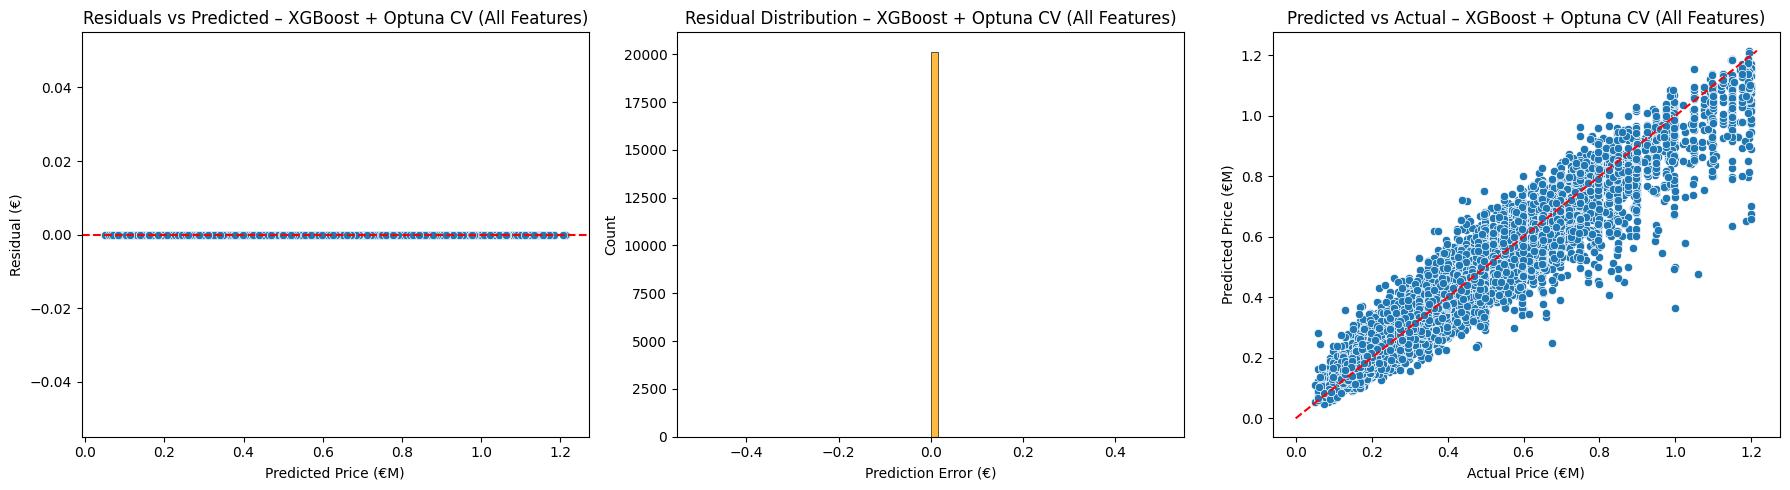

Diagnostics (Top RF Features):


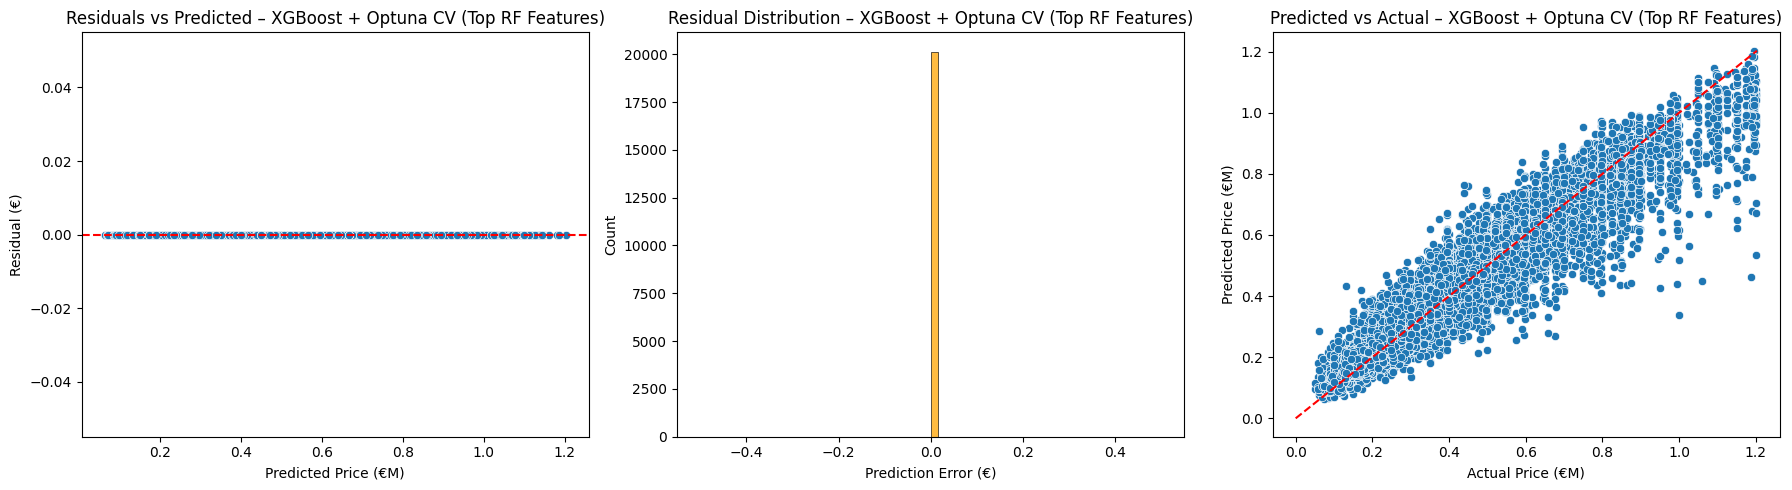

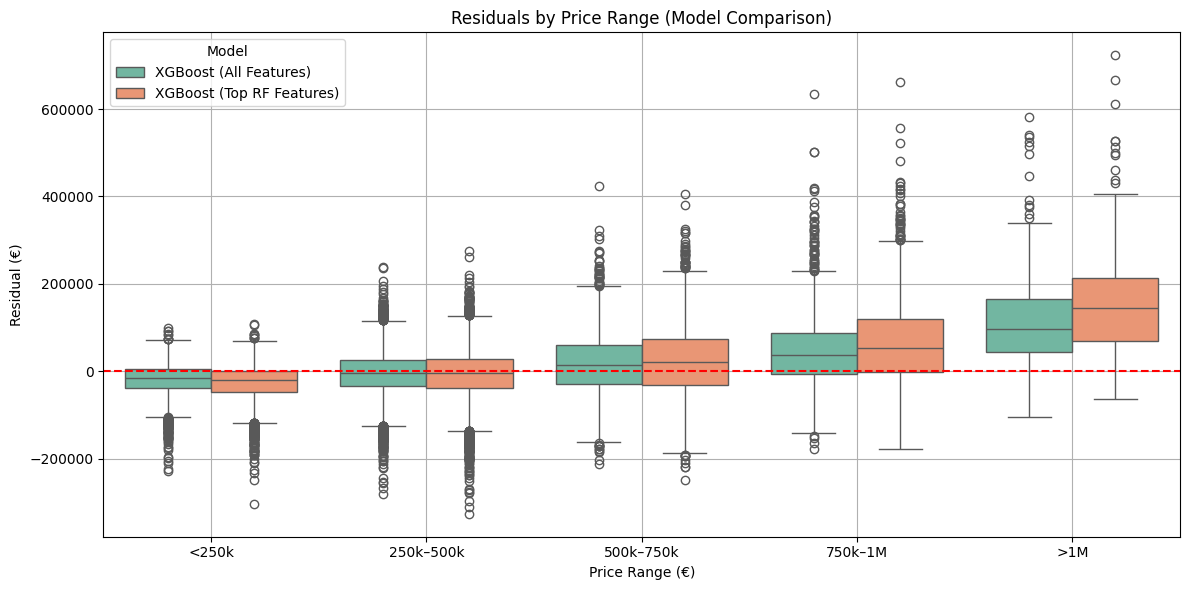

'\nModelEvaluator.plot_shap_comparison_beeswarm(\n    model_all=model_all,\n    x_all=X_reduced,\n    model_top=model_top,\n    x_top=X_top\n)\n'

In [5]:
import sys, os

# Add the project root to the Python path
project_root = os.path.abspath("../..")
sys.path.append(project_root)

import optuna
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from utils.constants import ML_READY_DATA_FILE, TEST_MODE
from utils.data_loader import DataLoader
from utils.model_evaluator import ModelEvaluator
from utils.experiment_tracker import ExperimentTracker
from utils.model_visualizer import ModelVisualizer
from utils.model_table import ModelComparativelTable  

import numpy as np
import pandas as pd


# Root Mean Squared Error
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

if TEST_MODE:
    print("TEST_MODE is ON – running in test mode (reduced data, fewer trials).")
else:
    print("TEST_MODE is OFF – full training is active.")

# Step 1: Load and clean dataset
loader = DataLoader(ML_READY_DATA_FILE)
df = loader.load_data()

X = df.drop(columns=["price"])
y = df["price"]

# Remove low-variance features
selector = VarianceThreshold(threshold=0.01)
selector.fit(X)  # Fit the selector on the full dataset
X_reduced = X.loc[:, selector.get_support()]

# Step 3: Extract top 30 features using Random Forest
rf_model_all = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model_all.fit(X_reduced, y)

importances = rf_model_all.feature_importances_
feature_ranking = pd.Series(importances, index=X_reduced.columns).sort_values(ascending=False)
top_features = feature_ranking.head(30).index.tolist()
X_top = X_reduced[top_features]

# Step 4: Define Optuna tuning function
def tune_xgboost_with_optuna(X_data, y_data, n_trials=50):
    def objective(trial):
        params = {
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "n_estimators": trial.suggest_int("n_estimators", 100, 800),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
            "min_child_weight": trial.suggest_float("min_child_weight", 1, 10),
            "gamma": trial.suggest_float("gamma", 0, 5),
        }
        model = xgb.XGBRegressor(**params, objective="reg:squarederror", random_state=42, n_jobs=-1)
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = -cross_val_score(model, X_data, y_data, scoring="neg_root_mean_squared_error", cv=cv)
        return scores.mean()

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)
    return study


# Step 5: Tune and train both models
n_trials = 3 if TEST_MODE else 50

study_all = tune_xgboost_with_optuna(X_reduced, y, n_trials=n_trials)
model_all = xgb.XGBRegressor(**study_all.best_params, objective="reg:squarederror", random_state=42, n_jobs=-1)
model_all.fit(X_reduced, y)
y_pred_all = model_all.predict(X_reduced)

study_top = tune_xgboost_with_optuna(X_top, y, n_trials=n_trials)
model_top = xgb.XGBRegressor(**study_top.best_params, objective="reg:squarederror", random_state=42, n_jobs=-1)
model_top.fit(X_top, y)
y_pred_top = model_top.predict(X_top)

# Step 6: Evaluate models
evaluator_all = ModelEvaluator("XGBoost + Optuna CV (All Features)")
mae_all, rmse_all, r2_all = evaluator_all.evaluate(y, y_pred_all)

evaluator_top = ModelEvaluator("XGBoost + Optuna CV (Top RF Features)")
mae_top, rmse_top, r2_top = evaluator_top.evaluate(y, y_pred_top)

# Step 7: Log results
# Ajout du suffixe TEST si nécessaire
suffix = " [TEST]" if TEST_MODE else ""

# Init tracker
tracker = ExperimentTracker()

# Log modèle All Features
df_metrics_all = tracker.log_and_get_evaluations(
    model=f"XGBoost + Optuna CV (All Features){suffix}",
    experiment=f"XGBoost with Optuna (All Features){suffix}",
    mae=mae_all,
    rmse=rmse_all,
    r2=r2_all,
)

# Log modèle Top RF Features
df_metrics_top = tracker.log_and_get_evaluations(
    model=f"XGBoost + Optuna CV (Top RF Features){suffix}",
    experiment=f"XGBoost with Optuna (Top RF Features){suffix}",
    mae=mae_top,
    rmse=rmse_top,
    r2=r2_top,
)

# Step 8: Display evaluation summary
print("Evaluation Summary (All Features):")
evaluator_all.display_model_summary(df_metrics_all)

print("Evaluation Summary (Top RF Features):")
evaluator_top.display_model_summary(df_metrics_top)

# Step 9: Visual diagnostics
print("Diagnostics (All Features):")
visualizer_all = ModelVisualizer(model_all, X_reduced, y, model_name="XGBoost + Optuna CV (All Features)")
visualizer_all.plot_all_diagnostics()

print("Diagnostics (Top RF Features):")
visualizer_top = ModelVisualizer(model_top, X_top, y, model_name="XGBoost + Optuna CV (Top RF Features)")
visualizer_top.plot_all_diagnostics()


ModelEvaluator.plot_price_range_residuals_side_by_side(
    y,
    y_pred_all,
    y_pred_top,
    model_names=("XGBoost (All Features)", "XGBoost (Top RF Features)")
)

"""
ModelEvaluator.plot_shap_comparison_beeswarm(
    model_all=model_all,
    x_all=X_reduced,
    model_top=model_top,
    x_top=X_top
)
"""



In [4]:
import sys, os

# Add the project root to the Python path
project_root = os.path.abspath("../..")
sys.path.append(project_root)

import joblib
from datetime import datetime
from utils.constants import TEST_MODE, MODELS_DIR

# Create timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

# Add suffix if in TEST mode
suffix = "_TEST" if TEST_MODE else ""

# Define subdirectory for .pkl files
PKL_DIR = os.path.join(MODELS_DIR, "pkl")
os.makedirs(PKL_DIR, exist_ok=True)

# Build filenames
filename_all = f"xgboost_optuna_all_{timestamp}{suffix}.pkl"
filename_top = f"xgboost_optuna_top30_{timestamp}{suffix}.pkl"

# Save models
joblib.dump(model_all, os.path.join(PKL_DIR, filename_all))
joblib.dump(model_top, os.path.join(PKL_DIR, filename_top))

print(f"[✔] Models saved to '{PKL_DIR}' as:\n - {filename_all}\n - {filename_top}")


[✔] Models saved to 'e:\_SoftEng\_BeCode\real-estate-price-predictor\models\pkl' as:
 - xgboost_optuna_all_20250629_0955_TEST.pkl
 - xgboost_optuna_top30_20250629_0955_TEST.pkl
